In [74]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import diffusers
import transformers
import sys
import shutil
import time
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline, StableDiffusionImg2ImgPipeline
import torch
import os
import random
import requests
from io import BytesIO
import numpy as np
import subprocess
from torchvision import models, transforms
import dlib
from PIL import Image, ImageFilter, ImageDraw, ImageEnhance
import cv2
from pathlib import Path
import math
import matplotlib.pyplot as plt

from scipy.ndimage import binary_closing
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

device = "cuda" if torch.cuda.is_available() else "cpu"

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

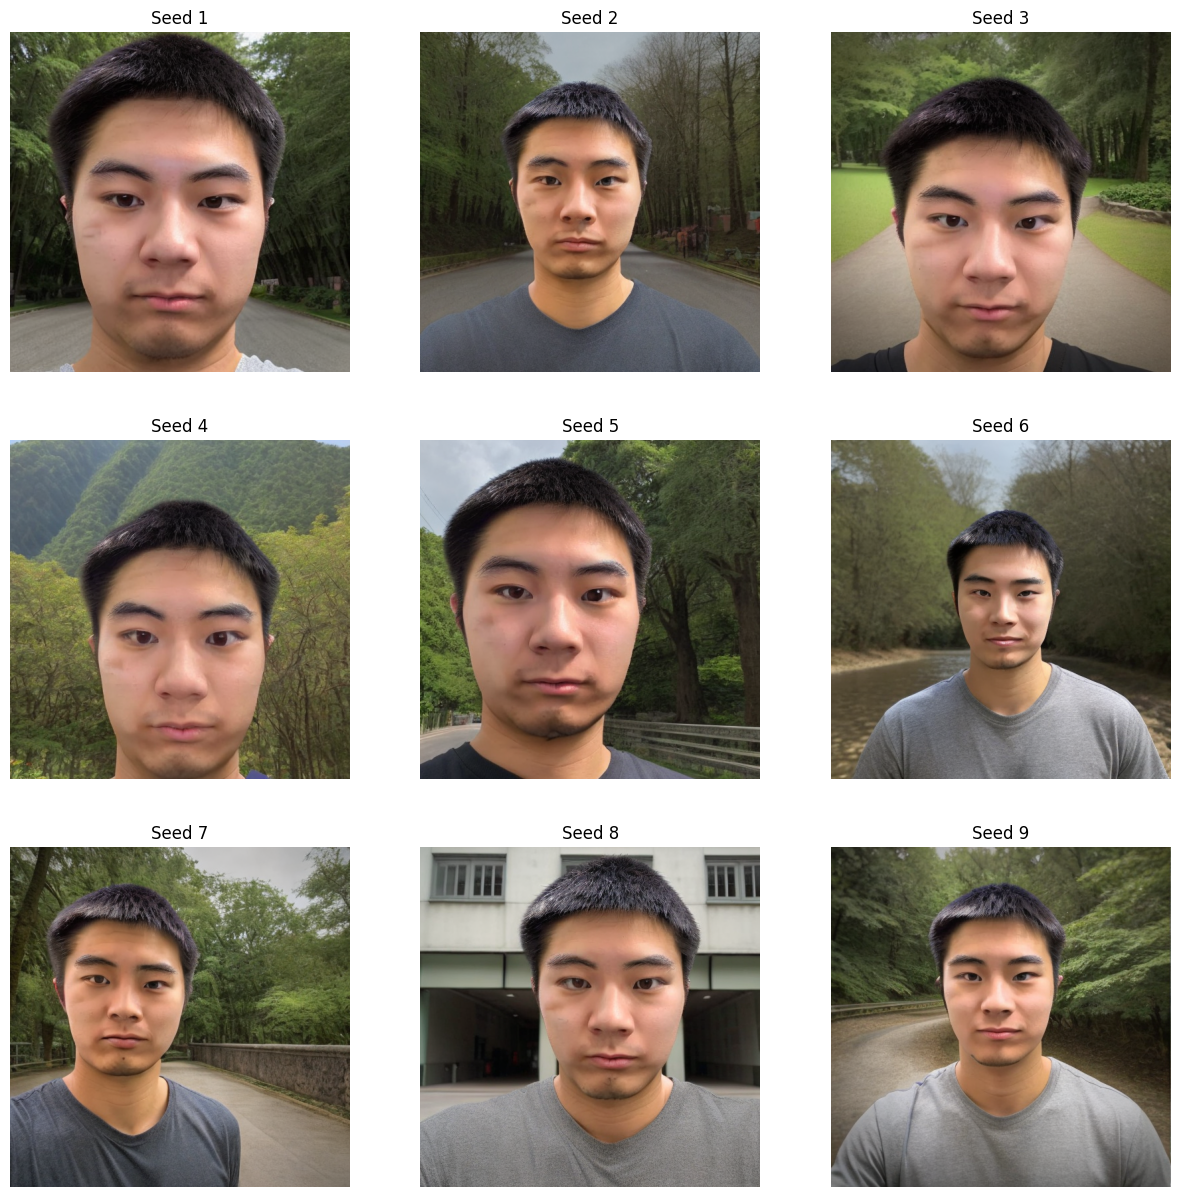

In [5]:
model_path = "ohmw_man_dreambooth"

pipe = StableDiffusionPipeline.from_pretrained(model_path)
pipe = pipe.to("cuda")

prompt = "photo of ohmw man outdoors"



num_images = 9

# 30 and 15 work
# for "hoto of ohmw man outdoors"

# larger steps (50-100)
# for something like: "photo of ohmw man in a suit outdoors"
# but this is because when training we weight the masked regions for the face and the body the same (1), maybe if we weighed it
# differently like 1 for face + skin and 0.5 for body then it could produce outputs with better faces
# and still somewhat resemble the body of the person
steps = 30


# below 2 and above 4 starts to get a bit weird
# usually 3.5 was good
guidance_scale = 7.5



images = []
for seed in range(1, num_images + 1):
    result = pipe(
        prompt=prompt,
        num_inference_steps=steps,
        generator=torch.Generator("cuda").manual_seed(seed),
        width=512,
        height=512,
        strength=1.0,
        guidance_scale=guidance_scale,
    )
    images.append(result.images[0])
    
num_images = len(images)
rows = math.ceil(num_images / 3)
fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
if num_images <= 3:
    axs = np.array([axs])
for i, img in enumerate(images):
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"Seed {i+1}")
    ax.axis('off')
for j in range(i + 1, rows * 3):
    axs[j // 3, j % 3].axis('off')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

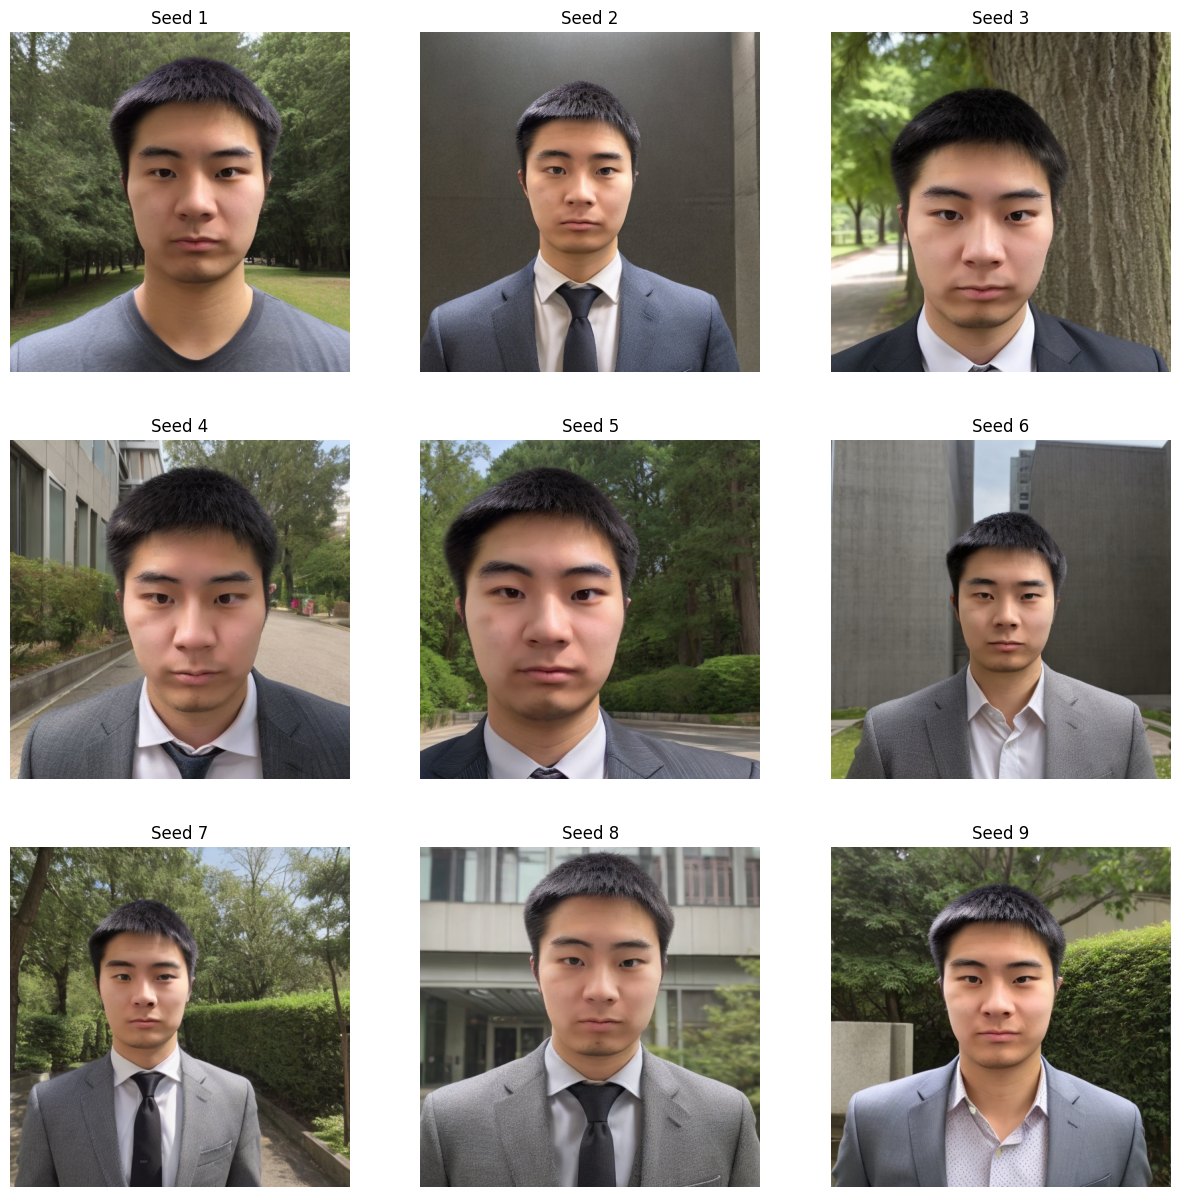

In [16]:
prompt = "photo of ohmw man in a suit outdoors"

num_images = 9
steps = 30

guidance_scale = 4

images = []
for seed in range(1, num_images + 1):
    result = pipe(
        prompt=prompt,
        num_inference_steps=steps,
        generator=torch.Generator("cuda").manual_seed(seed),
        width=512,
        height=512,
        strength=1.0,
        guidance_scale=guidance_scale,
    )
    images.append(result.images[0])

num_images = len(images)
rows = math.ceil(num_images / 3)
fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
if num_images <= 3:
    axs = np.array([axs])
for i, img in enumerate(images):
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"Seed {i+1}")
    ax.axis('off')
for j in range(i + 1, rows * 3):
    axs[j // 3, j % 3].axis('off')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

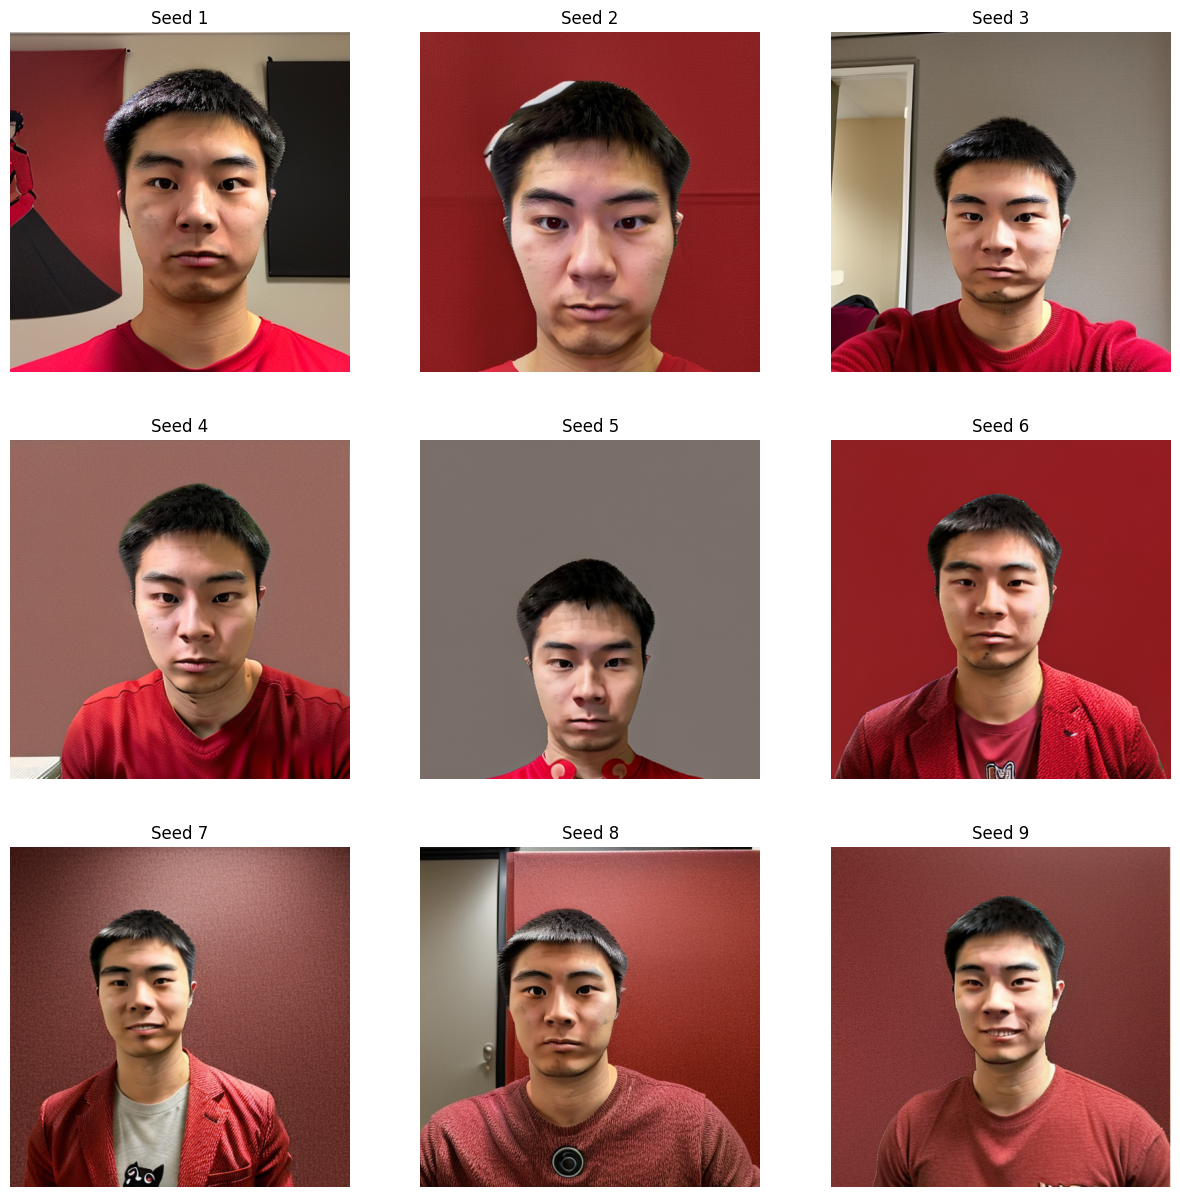

In [9]:
prompt = "photo of ohmw man in a red suit in new york"

num_images = 9
steps = 15

guidance_scale = 10

images = []
for seed in range(1, num_images + 1):
    result = pipe(
        prompt=prompt,
        num_inference_steps=steps,
        generator=torch.Generator("cuda").manual_seed(seed),
        width=512,
        height=512,
        strength=1.0,
        guidance_scale=guidance_scale,
    )
    images.append(result.images[0])
    
num_images = len(images)
rows = math.ceil(num_images / 3)
fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
if num_images <= 3:
    axs = np.array([axs])
for i, img in enumerate(images):
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"Seed {i+1}")
    ax.axis('off')
for j in range(i + 1, rows * 3):
    axs[j // 3, j % 3].axis('off')
plt.show()

In [149]:
# prompt = "photo of ohmw man outdoors"
# steps = 15
# guidance_scale = 3.5


# test_image = pipe(prompt=prompt,
#         num_inference_steps=steps,
#         guidance_scale=guidance_scale,
#         generator=torch.Generator("cuda").manual_seed(1),
#         width=512,
#         height=512,
#         strength=1.0).images[0]

# test_image.save("output_image.jpg")
# test_image.show()

# Im2Im

But lets make it our BG image

  0%|          | 0/25 [00:00<?, ?it/s]

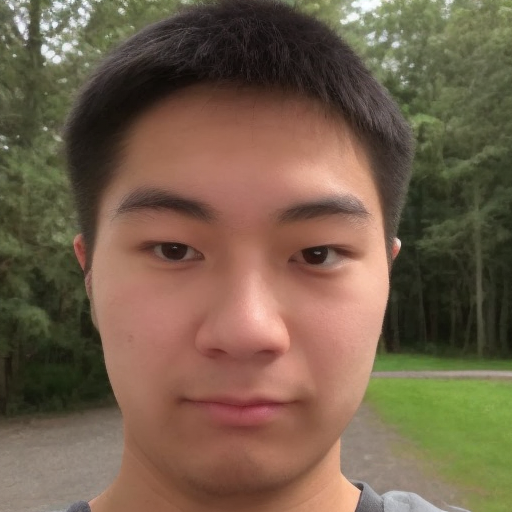

In [112]:

model_path = "ohmw_man_dreambooth"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_path)
pipe = pipe.to("cuda")

input_image_path = "output_image.jpg"
input_image = Image.open(input_image_path).convert("RGB")


prompt = "A photo of ohmw outdoors"
num_inference_steps = 50
guidance_scale = 7.5

output_images = pipe(
    prompt=prompt,
    init_image=input_image,
    generator=torch.Generator("cuda").manual_seed(1),
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
)

generated_image = output_images.images[0]
generated_image.show()